# Nationalhymnen: Analyse der Midi-Dateien
### Ressourcen: 
Die hier verwendeten Midi-Dateien stammen aus zwei Quellen: 
* https://www.kaggle.com/awesomepgm/national-anthems-of-every-country: Datenbank mit allen Midi-Dateien. 
* https://www.midiworld.com/search/1/?q=national%20anthems

In [404]:
# Importieren der nötigen Biliotheken.
from music21 import * #converter, corpus, instrument, midi, note, chord, pitch
environment.set('musescoreDirectPNGPath', '/usr/bin/musescore')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from statistics import median
import numpy as np

In [209]:
# Funktion zum Importieren der Midi-Datei. Der Rhythmuskanal wird deaktiviert. 
def open_midi(midi_path, remove_drums):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          
    return midi.translate.midiFileToStream(mf)

In [506]:
# Einige Analysefunktionen.

# Welche Instrumente kommen in der betreffenden Midi-Datei zum Einsatz?
def suche_instrumente(midi):
    l = list()
    partStream = midi.parts.stream()
    for p in partStream:
        aux = p
        l.append(p.partName)
    return l

def suche_tonlängen(midi):
    tonlängen_liste = list()
    partStream = midi.parts.stream()
    for n in partStream.flat.notes:
        tonlängen_liste.append(n.duration.quarterLength)
    return tonlängen_liste

def suche_metrum(midi):
    tempo_liste = list()
    for part in midi:
        for el in part:
            if el.classes[0] == 'MetronomeMark':
                tempo_liste.append(el.number)
    return tempo_liste

# Extrahieren der Taktart, der Tonart und der Instrumente.
def musikanalyse(midi):
    timeSignature = midi.getTimeSignatures()[0]
    taktart = str(timeSignature.beatCount) + '/' + str(timeSignature.denominator)
    music_analysis = midi.analyze('key')
    tonart = music_analysis
    wahrscheinlichkeit = music_analysis.correlationCoefficient
    
    instrumente = suche_instrumente(midi)
    anz_instrumente = len(instrumente)
    
    metrum = suche_metrum(midi)
    metrum_max = max(metrum)
    metrum_min = min(metrum)
    metrum_mean = median(metrum)
    metrum_changes = len(metrum)
    
    alle_tonlängen = suche_tonlängen(midi)
    if len(alle_tonlängen) > 0:
        tonlängen_mean = np.mean(alle_tonlängen)
    else:
        tonlängen_mean = np.NaN
        
    return [taktart, str(tonart), wahrscheinlichkeit, instrumente, anz_instrumente, metrum_max, metrum_min, metrum_mean, metrum_changes, alle_tonlängen, tonlängen_mean]   

In [507]:
# Importieren der Basisinformationen. 
df = pd.read_csv('länderübersicht.csv', index_col='index')

In [511]:
# Die Mididateien werden eingelesen und analysiert. 
analyse_dict = dict()

for index, row in df.iterrows():
    #try:
    base_midi = open_midi('midi/' + row['midi'], True)
    analyse_dict[index] = musikanalyse(base_midi)

# Die Informationen werden dem DataFrame angefügt. 
df = pd.merge(df[['midi']], pd.DataFrame.from_dict(analyse_dict, orient='index', columns=['taktart', 'tonart', 'tonart_prob', 'instrumente', 'anz_instrumente', 'metrum_max', 'metrum_min', 'metrum_mean', 'metrum_wechsel', 'tonlängen', 'tonlänge_mittel']), left_index=True, right_index=True)

In [510]:
# Ein erster Blick auf die Daten.
df.head()

,midi,taktart,tonart,tonart_prob,instrumente,anz_instrumente,metrum_max,metrum_min,metrum_mean,metrum_wechsel,tonlängen,tonlänge_mittel
Afghanistan,afghanistan.mid,4/4,E- major,0.896338,"[Trombone, StringInstrument]",2,80.0,80.0,80.0,1,"[1.0, 1.25, 1.0, 1.25, 0.0, 0.0, 0.0, 0.0, 0.2...",0.520492
Ägypten,egypt.mid,4/4,F major,0.903261,"[StringInstrument, StringInstrument]",2,96.0,96.0,96.0,1,"[0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75,...",0.527872
Albanien,albania.mid,4/4,G major,0.910018,"[StringInstrument, StringInstrument]",2,110.0,110.0,110.0,1,"[2/3, 0.5, 2/3, 0.5, 2/3, 2/3, 1.25, 2/3, 2/3,...",0.722420
Algerien,algeriea.mid,4/4,F major,0.908971,"[Trombone, StringInstrument]",2,110.0,110.0,110.0,1,"[0.25, 0.25, 0.25, 0.25, 1/3, 0.5, 1/3, 0.5, 0...",0.566667
Andorra,andorra.mid,4/4,G major,0.847000,[StringInstrument],1,110.0,110.0,110.0,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.357895


## Auswertungen

In [409]:
# Wie viele Hymnen sind erfasst?
len(df)

10

In [215]:
# In welchen Tonarten werden Hymnen normalerweise geschrieben? 
df['tonart'].value_counts()

F major     37
G major     35
B- major    28
C major     24
E- major    17
A- major     8
A major      7
D major      5
d minor      5
a minor      3
f minor      2
e minor      2
C# major     1
b- minor     1
g minor      1
F# major     1
Name: tonart, dtype: int64

In [217]:
# In welchen Taktarten werden Hymnen normalerweise geschrieben? 
df['taktart'].value_counts()

4/4    145
2/4     10
1/4     10
3/4      8
1/8      2
3/8      1
5/4      1
Name: taktart, dtype: int64

In [218]:
# Welche Länder haben Hymnen im Dreivierteltakt? 
df[df['taktart'] == '3/4']

,midi,taktart,tonart,tonart_prob,instrumente,anz_instrumente
Bulgarien,bulgaria.mid,3/4,a minor,0.956674,"[StringInstrument, StringInstrument]",2
Liechtenstein,liechtenstein.mid,3/4,F major,0.944721,[None],1
Mikronesien,micrones.mid,3/4,D major,0.919172,"[Trombone, StringInstrument, Church Bells, Org...",7
Schweiz,switzer.mid,3/4,B- major,0.871274,"[Trumpet, Horn, Trombone, Tuba, StringInstrume...",8
Swasiland,swazil.mid,3/4,A- major,0.882944,"[Trumpet, Horn, Trombone, Tuba, StringInstrume...",8
Vereinigte Staaten,united-s.mid,3/4,F# major,0.919507,"[Horn, Clarinet, StringInstrument, Celesta, Or...",8
Vereinigtes Königreich,united-k.mid,3/4,G major,0.925615,"[Trumpet, Tuba, Horn, Horn, Trumpet, Timpani, ...",11
Zypern,cyprus.mid,3/4,F major,0.955180,"[Clarinet, None, None, Acoustic Bass, None, El...",6


In [219]:
# Welches Land hat eine Hymne im 5/4-Takt?
df[df['taktart'] == '5/4']

,midi,taktart,tonart,tonart_prob,instrumente,anz_instrumente
Nigeria,nigeria.mid,5/4,F major,0.92912,"[Trumpet, Horn, Trombone, Tuba, StringInstrume...",10


In [ ]:
# Welches ist die Hymne mit dem höchsten Metrum?

In [ ]:
# Welches ist die Hymne mit dem tiefsten Metrum? 

In [ ]:
# Wie gross ist der durchschnittliche Notenwert? (Allenfalls können so "getragene" von "wirbligen" Hymnen
# unterschieden werden. Alles im Verhältnis zum Grundtempo.)



## Weitere Möglichkeiten

In [340]:
test = list()
for part in base_midi:
    for el in part:
        if el.classes[0] == 'MetronomeMark':
            test.append(el.number)

In [364]:
test[0].number

99.0

In [314]:
def tonlängen_median(midi): 
    tonlängen_liste = list()
    tempo = list()

    for part in base_midi:
        for el in part:
            if el.classes[0] == 'Note':
                tonlängen_liste.append(float(el.quarterLength))
            if el.classes[0] == 'MetronomeMark':
                tempo.append(el)
    return median(tonlängen_liste)

Counter({<music21.pitch.Pitch A5>: 15,
         <music21.pitch.Pitch B-5>: 12,
         <music21.pitch.Pitch C6>: 22,
         <music21.pitch.Pitch D6>: 16,
         <music21.pitch.Pitch E6>: 12,
         <music21.pitch.Pitch F6>: 7,
         <music21.pitch.Pitch G5>: 5,
         <music21.pitch.Pitch C#6>: 2,
         <music21.pitch.Pitch F5>: 1,
         <music21.pitch.Pitch F2>: 20,
         <music21.pitch.Pitch B-2>: 15,
         <music21.pitch.Pitch D2>: 15,
         <music21.pitch.Pitch A2>: 12,
         <music21.pitch.Pitch C3>: 42,
         <music21.pitch.Pitch G2>: 6,
         <music21.pitch.Pitch D3>: 10,
         <music21.pitch.Pitch C2>: 9,
         <music21.pitch.Pitch F3>: 3})

0.3333333333333333

In [220]:
for part in base_midi:
    for thisnote in part:
        print(thisnote)

Clarinet
<music21.tempo.MetronomeMark Quarter=99.0>
C major
<music21.meter.TimeSignature 3/4>
<music21.note.Rest rest>
<music21.note.Note A>
<music21.note.Rest rest>
<music21.note.Note B->
<music21.note.Note C>
<music21.note.Rest rest>
<music21.note.Note B->
<music21.note.Note A>
<music21.note.Rest rest>
<music21.note.Note B->
<music21.note.Note C>
<music21.note.Note A>
<music21.note.Note B->
<music21.note.Rest rest>
<music21.note.Note C>
<music21.note.Note D>
<music21.note.Rest rest>
<music21.note.Note D>
<music21.note.Note E>
<music21.note.Rest rest>
<music21.note.Note E>
<music21.note.Note F>
<music21.note.Rest rest>
<music21.note.Note G>
<music21.note.Rest rest>
<music21.note.Note A>
<music21.note.Note B->
<music21.note.Rest rest>
<music21.note.Note A>
<music21.note.Note G>
<music21.note.Rest rest>
<music21.note.Note A>
<music21.note.Note B->
<music21.note.Note G>
<music21.note.Rest rest>
<music21.note.Note C>
<music21.note.Rest rest>
<music21.note.Note C>
<music21.note.Note E>
<mu

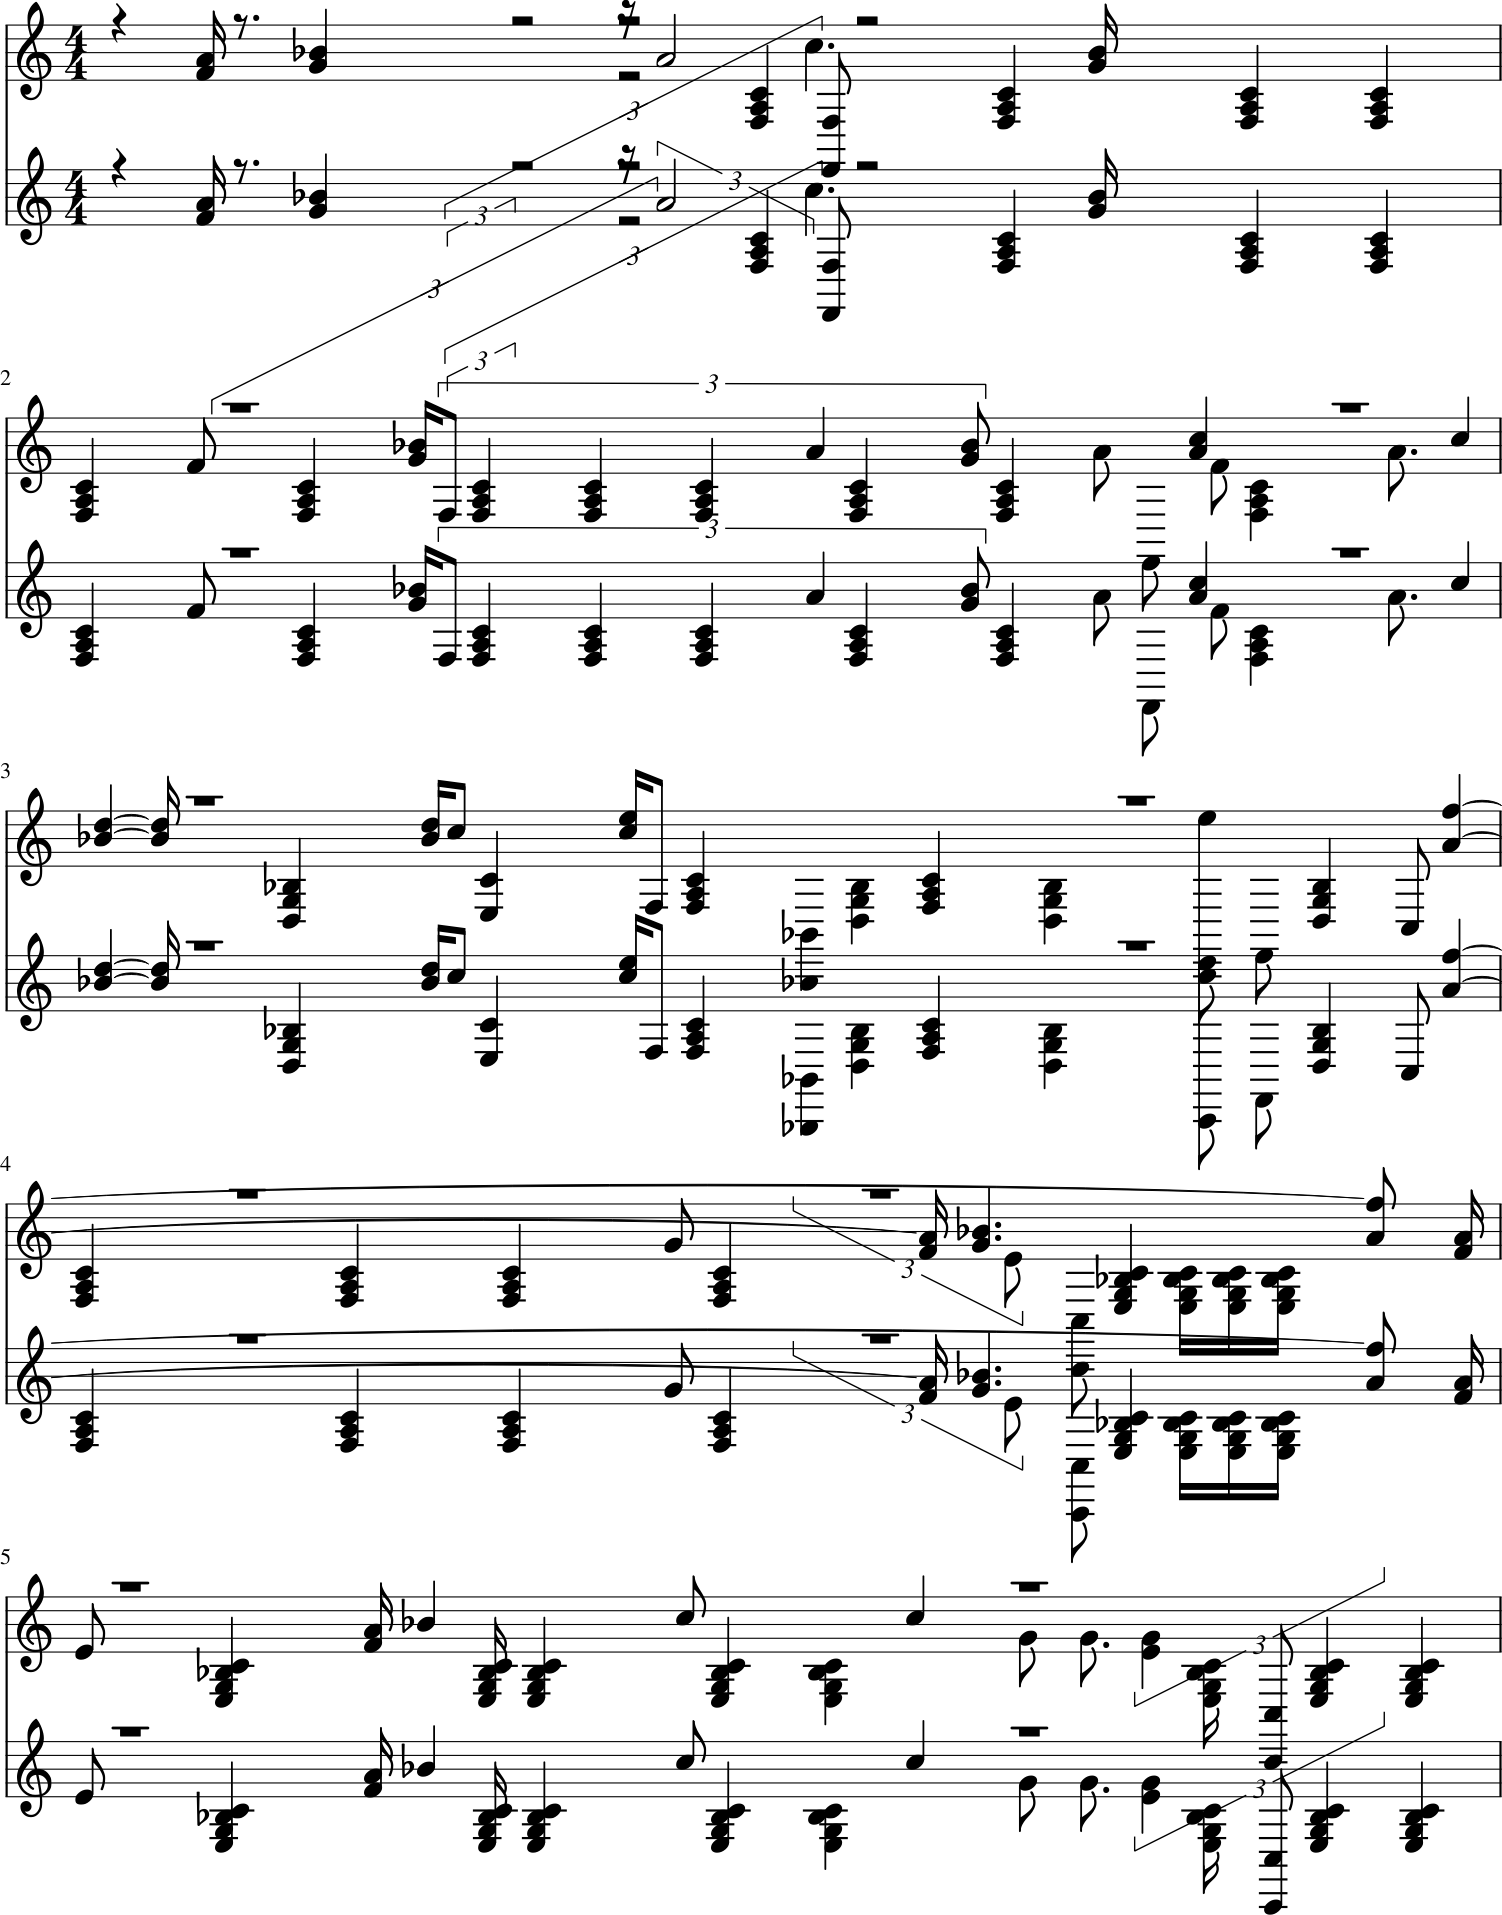

In [142]:
# Ausdrucken der Noten. 
s = base_midi.show()

In [71]:
# Wie lange dauert die Hymne? 

In [ ]:
# Wie hoch ist das Metrum?

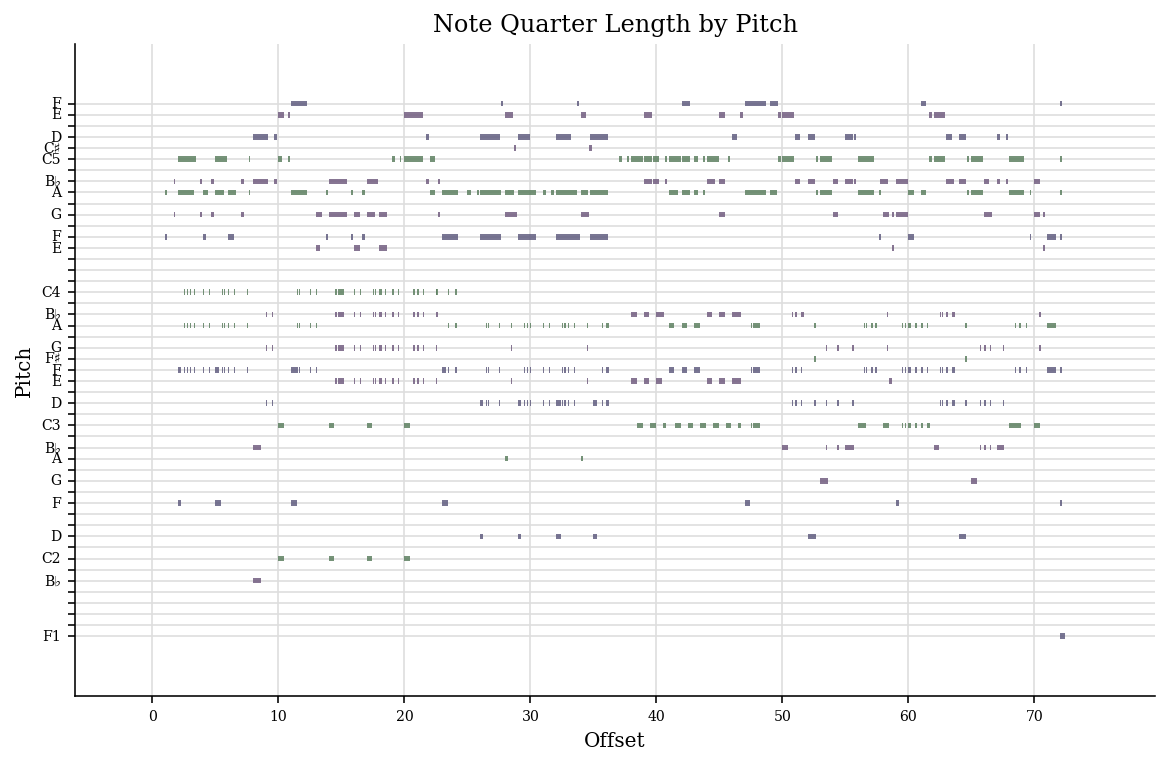

In [84]:
# Die Noten werden ausgegeben. 
base_midi.plot()

In [118]:
# Notenschlüssel bestimmen. 
base_midi.getClefs()

[<music21.clef.TrebleClef>]

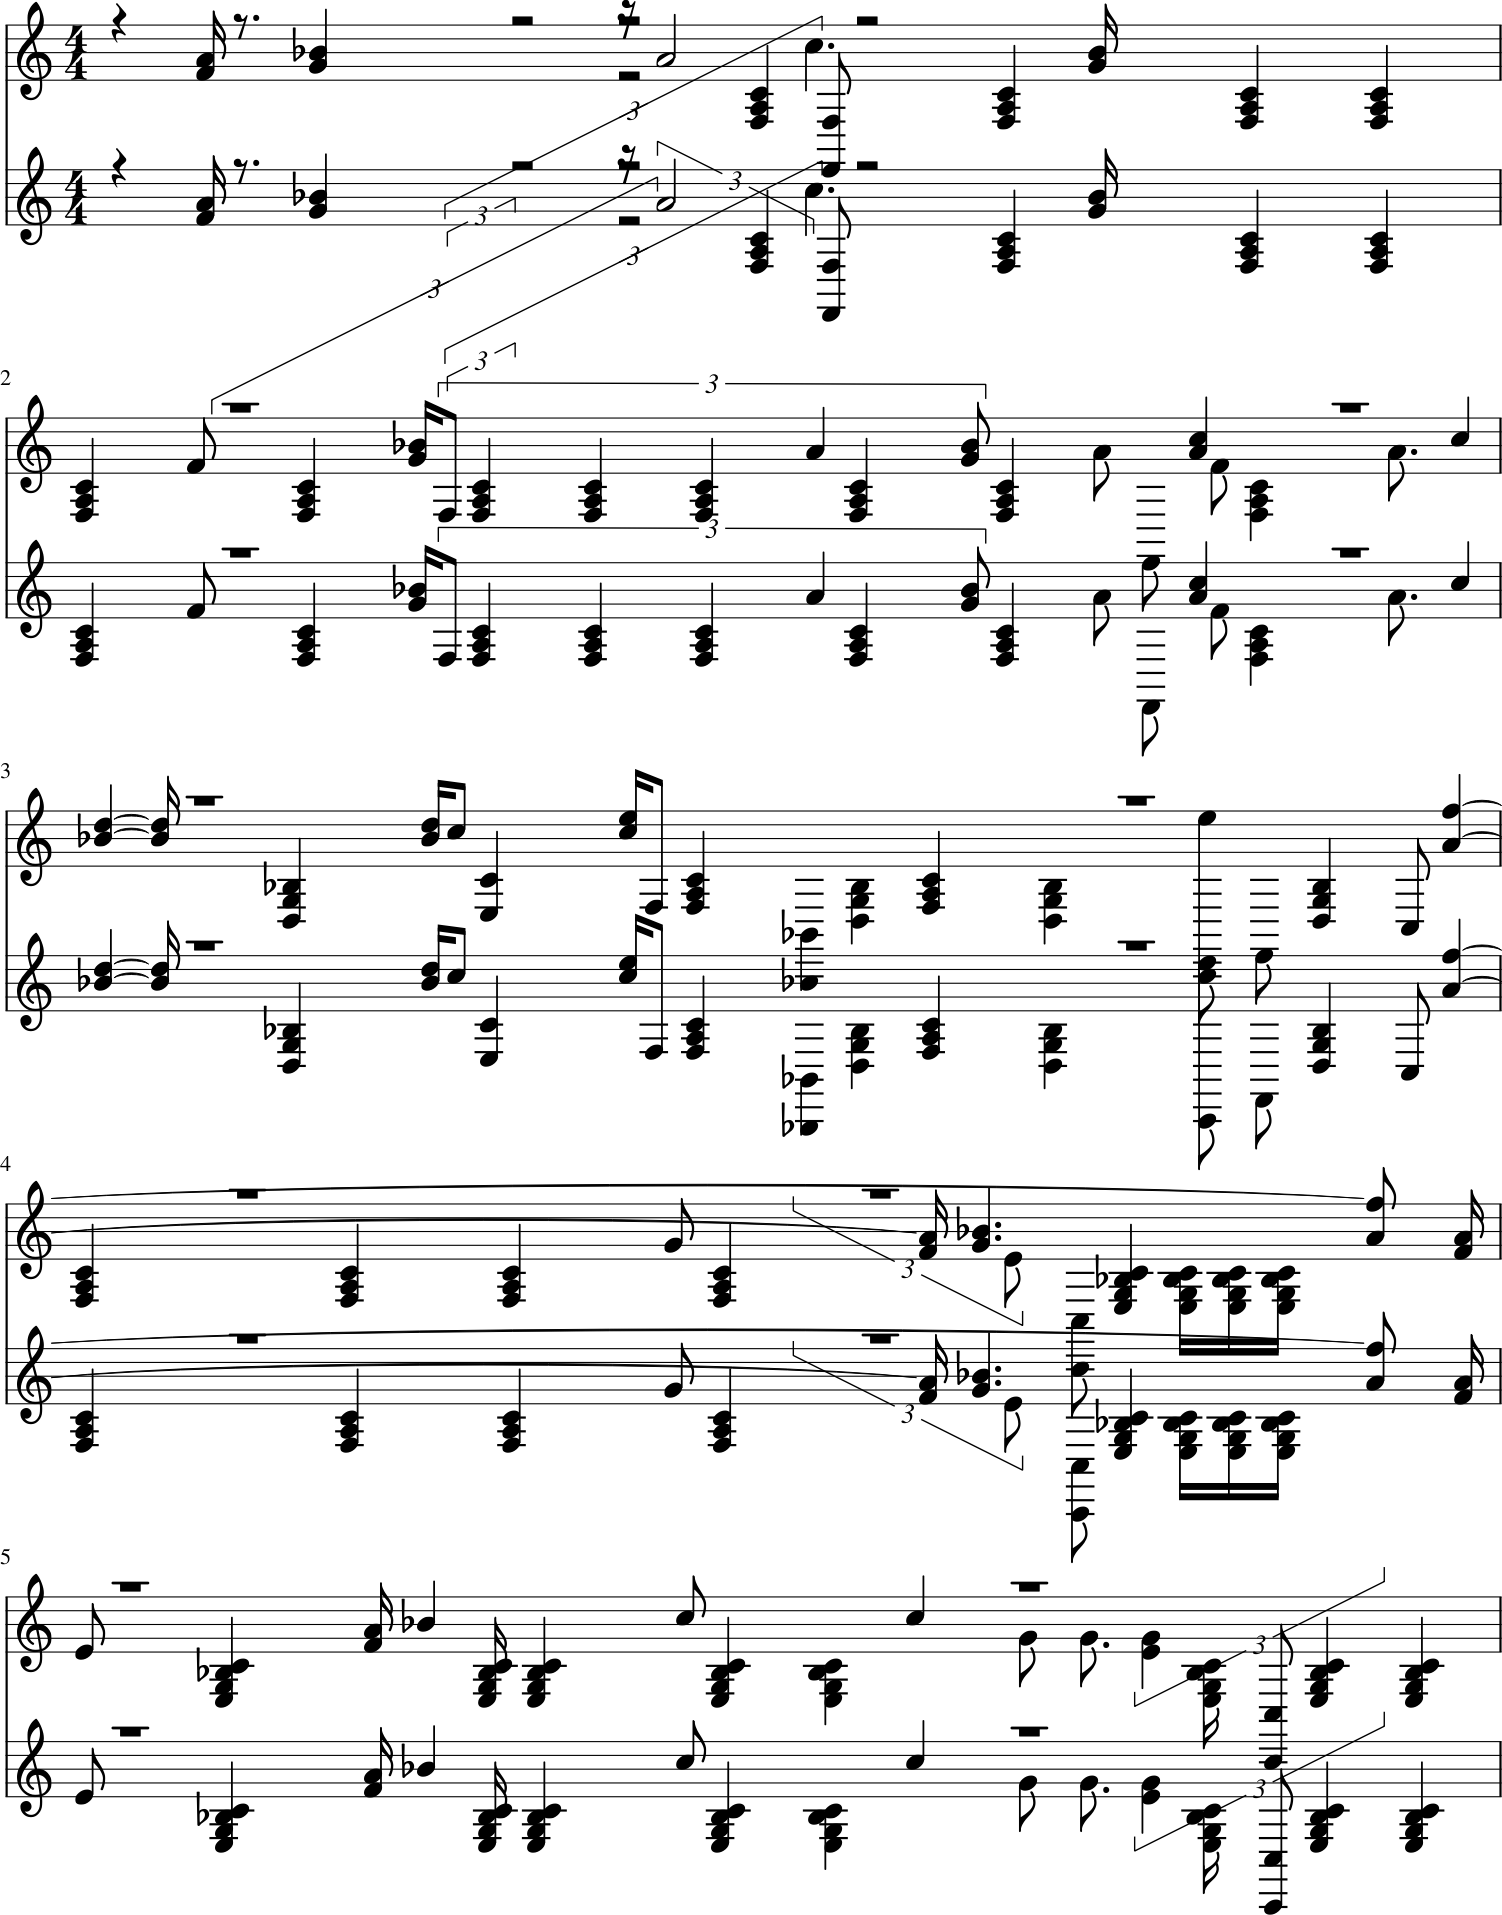

In [125]:
# Anzeigen der Partitur. 
base_midi.show()

In [126]:
for el in base_midi.iter.notes:
    print(el)

#base_midi.show('text')

In [137]:
for i in base_midi.recurse().notes:
    print(i.)

<music21.chord.Chord F4 A4>
<music21.chord.Chord B-4 G4>
<music21.note.Note A>
<music21.chord.Chord F3 C4 A3>
<music21.chord.Chord B-4 G4>
<music21.chord.Chord A3 F3 C4>
<music21.note.Note F>
<music21.chord.Chord F3 A3 C4>
<music21.chord.Chord B-4 G4>
<music21.note.Note F>
<music21.chord.Chord F3 A3 C4>
<music21.chord.Chord F3 C4 A3>
<music21.chord.Chord F3 C4 A3>
<music21.note.Note A>
<music21.chord.Chord F3 C4 A3>
<music21.chord.Chord B-4 G4>
<music21.chord.Chord F3 C4 A3>
<music21.chord.Chord C5 A4>
<music21.chord.Chord B-4 D5>
<music21.chord.Chord D3 B-3 G3>
<music21.chord.Chord B-4 D5>
<music21.note.Note C>
<music21.chord.Chord E3 C4>
<music21.chord.Chord C5 E5>
<music21.note.Note F>
<music21.chord.Chord F3 C4 A3>
<music21.chord.Chord F3 A3 C4>
<music21.chord.Chord A3 F3 C4>
<music21.chord.Chord F3 C4 A3>
<music21.chord.Chord F3 A3 C4>
<music21.note.Note G>
<music21.chord.Chord F3 A3 C4>
<music21.chord.Chord F4 A4>
<music21.chord.Chord G4 B-4>
<music21.chord.Chord C4 E3 B-3 G3>
<m

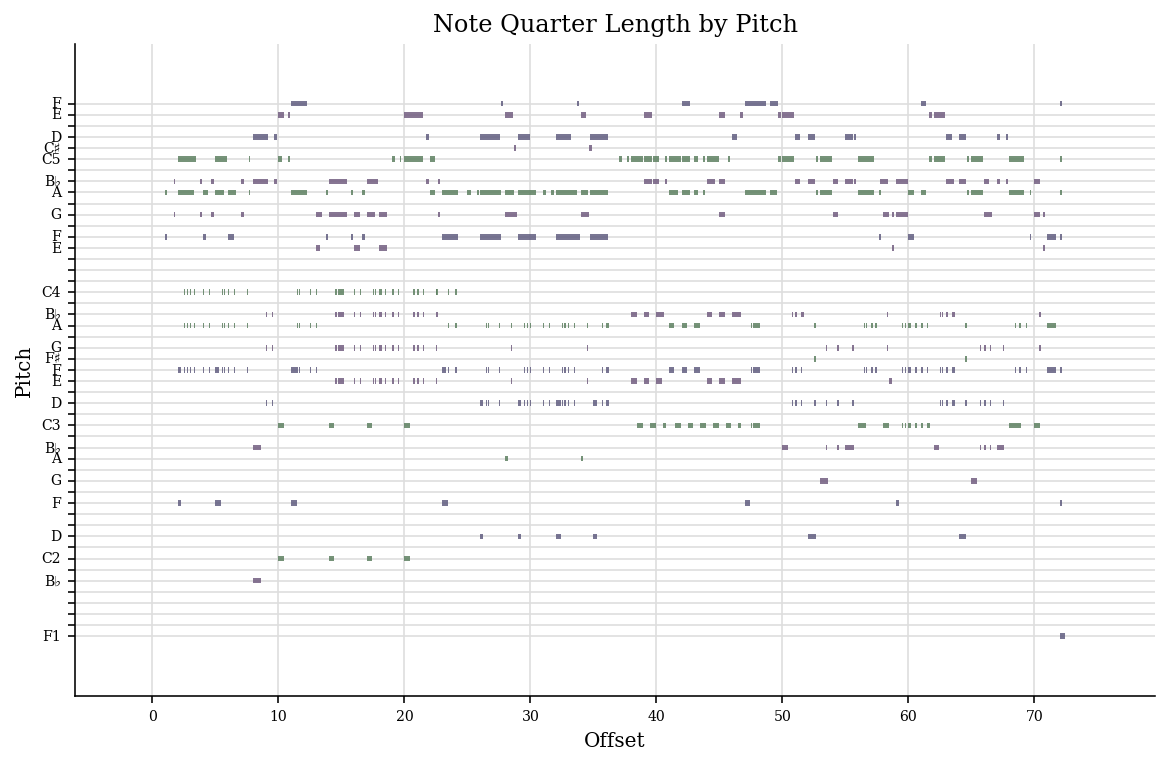

In [61]:
# Weitere Möglichkeit: Ein Diagramm wird gezeichnet. 
base_midi.plot()

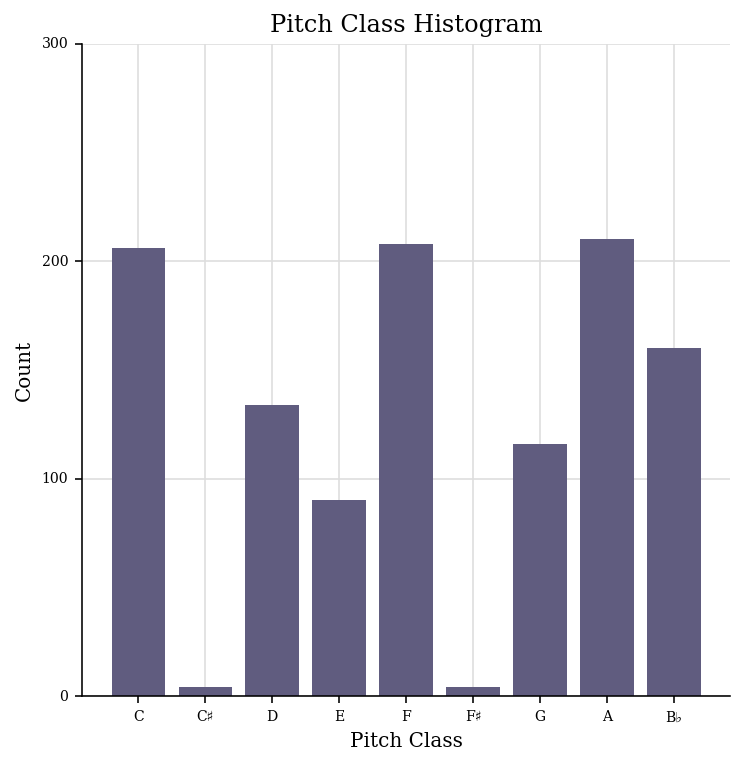

In [75]:
# Welche Töne werden wie oft gespielt? 
base_midi.plot('histogram', 'pitchClass', 'count')

In [169]:
# Gibt es Ähnlichkeien zu anderen Hymnen? 



In [170]:
s = corpus.parse('bach/bwv65.2.xml')

In [171]:
s

<music21.stream.Score 0x7f2a94eed8d0>

In [172]:
s.analyze('key')

<music21.key.Key of a minor>

In [179]:
for p in s.parts:
    for n in p.notes:
        print(n.octave)

In [193]:
test = base_midi.parts[0]
test = test.measures(1,2)

In [199]:
for n in test.notes:
    n.show()